# Projet Python Avancé - MOSEF

## On importe les packages nécessaires dans la suite du code

In [1]:
# Import des packages
import pandas as pd
import requests
from lxml import html
from unidecode import unidecode
from bs4 import BeautifulSoup
import urllib
import re
import matplotlib.pyplot as plt
import numpy as np

## Etape 1 : Récupération des informations du site pour initialiser la base

In [2]:
url_site = """https://www.pimkie.fr/c-toute-la-collection"""

Nous avons choisi ce site de vêtements de femmes. Durant cette première partie, nous allons récolter diverses informations comme les catégories, sous-catégories, nombre de produits, prix des produits, etc ... Pour cela, nous allons créer diverses fonctions.

Ces informations seront rentrées dans la base par la suite.

In [3]:
def recup_categorie(url):
    """
    Cette fonction, appliquée à l'accueil du site, permet de récupérer les grandes catégories des produits vendus.
    """
    # Ouvrir l'URL
    soup = BeautifulSoup(urllib.request.urlopen(url))
    # Stockage des informations
    Categorie = []
    Categorie_url = []
    Nb_Art_Categorie = []
    for a in soup.find_all('li', class_="category-element"): 
        p = re.compile('title="(.[^#<#\n]+)"',re.IGNORECASE) # Récupérer les noms des catégories
        match = p.findall(str(a))
        if (match != [] and match[0] not in Categorie):
            Categorie.append(match[0])
        p = re.compile('href="(.[^#"#\n]+)"',re.IGNORECASE) # Récupérer les url des pages des catégories
        match = p.findall(str(a))
        if (match != [] and match[0] not in Categorie_url):
            Categorie_url.append(match[0])
        p = re.compile('[0-9]+',re.IGNORECASE) # Récupérer les nombres
        match = p.findall(str(a))
        if match != []:
            Nb_Art_Categorie.append(int(match[0]))
    Nb_Art_Categorie = Nb_Art_Categorie[0:len(Categorie)]
    return(Categorie, Categorie_url, Nb_Art_Categorie)

In [4]:
# Appel de la fonction
Categorie, Categorie_url, Nb_Art_Categorie = recup_categorie(url_site)

In [5]:
# Vérification des résultats
print(Categorie)
print("##################################")
print(Categorie_url)
print("##################################")
print(Nb_Art_Categorie)

['Manteau', 'Veste', 'Pull et gilet', 'Jean', 'Blouse et chemise', 'Pantalon', 'Tshirt et top', 'Robe', 'Jupe', 'Combinaison', 'Short', 'Toute la collection']
##################################
['https://www.pimkie.fr/c-manteau', 'https://www.pimkie.fr/c-veste', 'https://www.pimkie.fr/c-pull-et-gilet', 'https://www.pimkie.fr/c-jean', 'https://www.pimkie.fr/c-blouse-et-chemise', 'https://www.pimkie.fr/c-pantalon', 'https://www.pimkie.fr/c-tshirt-et-top', 'https://www.pimkie.fr/c-robe', 'https://www.pimkie.fr/c-jupe', 'https://www.pimkie.fr/c-combinaison', 'https://www.pimkie.fr/c-short', 'https://www.pimkie.fr/c-toute-la-collection']
##################################
[19, 44, 70, 42, 46, 23, 98, 33, 26, 1, 5, 528]


In [6]:
# La catégorie "Toute la collection" ne sera pas utile dans la suite
nb_categorie = len(Categorie)
Categorie = Categorie[0:nb_categorie - 1]
Categorie_url = Categorie_url[0:nb_categorie - 1]
Nb_Art_Categorie = Nb_Art_Categorie[0:nb_categorie - 1]

Le nombre d'articles par catégorie permet de vérifier la bonne récupération des informations, cela ne sera pas stocké dans le dataframe par la suite. En revanche, il peut être intéressant de connaître la catégorie de chaque article et les url vont nous permettre de naviguer entre les pages.

## Etape 2 : Création d'une base avec les premières informations

In [7]:
colonnes = ['Nom','URL', 'Prix', 'Couleur', 'Sous_Catégorie', 'Catégorie_Identifiant', 'Catégorie','Catégorie_url']
row = []
compteur = 0
for i in Nb_Art_Categorie:
    for j in range(i):
        row.append(("","", "", "", "",j, Categorie[compteur], Categorie_url[compteur]))
    compteur += 1

In [8]:
df = pd.DataFrame() #creates a new dataframe that's empty
df = df.from_records(row, columns = colonnes)

In [ ]:
df.head(5)

## Etape 3 : Remplissage de la base

In [10]:
def recup_sous_categorie(df):
    """
    Cette fonction, appliquée aux pages des catégories, permet de récupérer la liste des produits vendus.
    """
    if df.Catégorie_Identifiant < 42:
        url = df.Catégorie_url
        # Ouvrir l'URL
        soup = BeautifulSoup(urllib.request.urlopen(url))
        a = soup.find_all('div',class_="product-name")[df.Catégorie_Identifiant] # Classe détaillant les produits présentés
        p = re.compile('title="(.[^#<#\n]+)"',re.IGNORECASE) # Récupérer les noms des produits
        match = p.findall(str(a))
        if (match != []): # On a trouvé un produit
            df.Nom = match[0] # On entre son nom
        p = re.compile('href="(.[^#<#\n]+)"\s',re.IGNORECASE) # Récupérer les url des produits 
        match = p.findall(str(a))
        if (match != []):
            df.URL = match[0] # Récupérer les urls des produits
    else:
        url = df.Catégorie_url + "?sz=" + str(42 * (int(df.Catégorie_Identifiant/42) +1))+ "&start=" +\
        str(42 * int(df.Catégorie_Identifiant/42))
        # Ouvrir l'URL
        soup = BeautifulSoup(urllib.request.urlopen(url))
        a = soup.find_all('div',class_="product-name")[df.Catégorie_Identifiant - 42 *\
                        int(df.Catégorie_Identifiant/42)] # Classe détaillant les produits présentés
        p = re.compile('title="(.[^#<#\n]+)"',re.IGNORECASE) # Récupérer les noms des produits
        match = p.findall(str(a))
        if (match != []): # On a trouvé un produit
            df.Nom = match[0] # On entre son nom
        p = re.compile('href="(.[^#<#\n]+)"\s',re.IGNORECASE) # Récupérer les url des produits 
        match = p.findall(str(a))
        if (match != []):
            df.URL = match[0] # Récupérer les urls des produits
    
    return(df)

In [112]:
def autre_info(df):
    """
    Cette fonction, appliquée à l'url du produit, permet de récupérer les informations relatives au produit
    """
    url = df.URL
    # On cherche la sous-catégorie du produit
    soup = BeautifulSoup(urllib.request.urlopen(url))
    # Récupération de la couleur
    a = soup.find('span',class_="text-color-uni") # On ne veut que le premier match
    p = re.compile('>(.[^#<#\n]+)<',re.IGNORECASE) # Récupérer les sous-cat
    match = p.findall(str(a))
    if (match != []): # On a trouvé un produit
        df.Couleur = match[0]
    else:
        a = soup.find('img',class_="lazyload") # On ne veut que le premier match
        p = re.compile(df.Nom + " " +'([a-zA-Zéè]+)',re.IGNORECASE) # Récupérer les sous-cat
        match = p.findall(str(a))
        if (match != []): # On a trouvé un produit
            df.Couleur = match[0]
    # Récupération du prix
    a = soup.find('span',class_="plain") # On ne veut que le premier match
    p = re.compile('>([0-9]+)<',re.IGNORECASE) # Récupérer les sous-cat
    match = p.findall(str(a))
    if (match != []): # On a trouvé un produit
        df.Prix = int(match[0])
    return df

In [113]:
from threading import Thread

class Calcul(Thread):

    """Thread chargé simplement d'afficher un mot dans la console."""

    def __init__(self, data, funct):
        Thread.__init__(self)
        self.data = data
        self.funct = funct
        

    def run(self):
        """Code à exécuter pendant l'exécution du thread."""
        self.data = self.data.apply(recup_sous_categorie, axis = 1)
        self.data = self.data.apply(autre_info, axis = 1)

# Création des threads
N = int(len(df)/10)
thread_1 = Calcul(df[0:N], 1)
thread_2 = Calcul(df[N:2*N], 1)
thread_3 = Calcul(df[2*N:3*N], 1)
thread_4 = Calcul(df[3*N:4*N], 1)
thread_5 = Calcul(df[4*N:5*N], 1)
thread_6 = Calcul(df[5*N:6*N], 1)
thread_7 = Calcul(df[6*N:7*N], 1)
thread_8 = Calcul(df[7*N:8*N], 1)
thread_9 = Calcul(df[8*N:9*N], 1)
thread_10 = Calcul(df[9*N:len(df)], 1)

In [114]:
# Lancement des threads
thread_1.start()
thread_2.start()
thread_3.start()
thread_4.start()
thread_5.start()
thread_6.start()
thread_7.start()
thread_8.start()
thread_9.start()
thread_10.start()

# Attend que les threads se terminent
thread_1.join()
thread_2.join()
thread_3.join()
thread_4.join()
thread_5.join()
thread_6.join()
thread_7.join()
thread_8.join()
thread_9.join()
thread_10.join()

In [115]:
df = pd.concat([thread_1.data, thread_2.data, thread_3.data, thread_4.data, thread_5.data, \
           thread_6.data, thread_7.data, thread_8.data, thread_9.data, thread_10.data], axis=0)

In [116]:
df.head(60)

,Nom,URL,Prix,Couleur,Sous_Catégorie,Catégorie_Identifiant,Catégorie,Catégorie_url
0,Parka à capuche,https://www.pimkie.fr/p/parka-a-capuche-280247...,49,kaki,,0,Manteau,https://www.pimkie.fr/c-manteau
1,Parka imperméable,https://www.pimkie.fr/p/parka-impermeable-2802...,69,noir,,1,Manteau,https://www.pimkie.fr/c-manteau
2,Doudoune à capuche,https://www.pimkie.fr/p/doudoune-a-capuche-280...,65,noir,,2,Manteau,https://www.pimkie.fr/c-manteau
3,Manteau long avec laine,https://www.pimkie.fr/p/manteau-long-avec-lain...,69,kaki,,3,Manteau,https://www.pimkie.fr/c-manteau
4,Manteau long avec laine,https://www.pimkie.fr/p/manteau-long-avec-lain...,69,caramel,,4,Manteau,https://www.pimkie.fr/c-manteau
5,Trench avec ceinture,https://www.pimkie.fr/p/trench-avec-ceinture-2...,29,beige,,5,Manteau,https://www.pimkie.fr/c-manteau
6,Manteau en fausse fourrure,https://www.pimkie.fr/p/manteau-en-fausse-four...,59,blanc,,6,Manteau,https://www.pimkie.fr/c-manteau
7,Manteau à capuche,https://www.pimkie.fr/p/manteau-a-capuche-2802...,55,noir,,7,Manteau,https://www.pimkie.fr/c-manteau
8,Doudoune légère,https://www.pimkie.fr/p/doudoune-legere-280241...,29,noir,,8,Manteau,https://www.pimkie.fr/c-manteau
9,Trench suédine,https://www.pimkie.fr/p/trench-suedine-280248C...,49,vert,,9,Manteau,https://www.pimkie.fr/c-manteau


## Etape 4 : Analyser les informations récupérées

#### 1) Nombre d'articles par catégorie

In [57]:
df_categorie = df.groupby(by = "Catégorie").count()

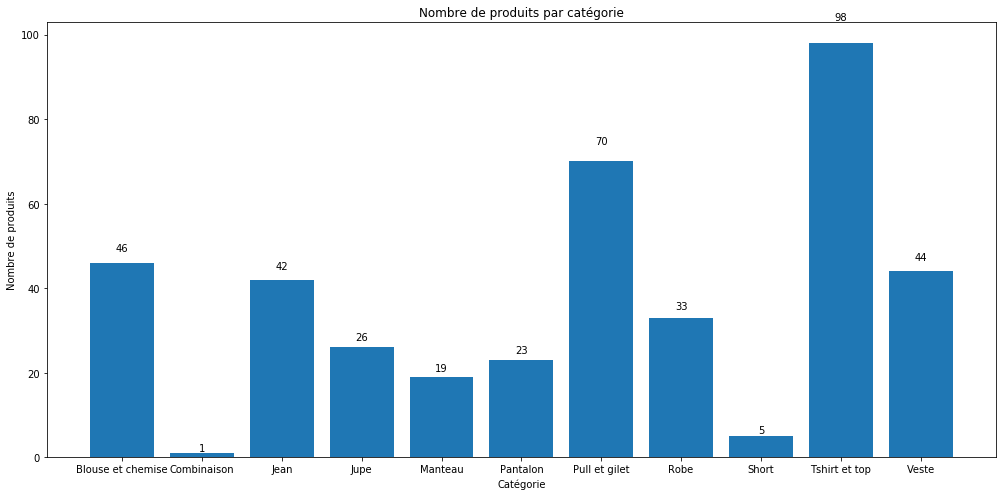

In [58]:
#fig = plt.figure(1, figsize=(15, 13))
fig, ax = plt.subplots(1, figsize=(17, 8))
bar_plot = plt.bar(np.arange(len(df_categorie)), df_categorie.Nom)
plt.xticks(np.arange(len(df_categorie)), df_categorie.index)
bar_label = df_categorie.Nom
for idx,rect in enumerate(bar_plot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            bar_label[idx],
                ha='center', va='bottom', rotation=0)
plt.title("Nombre de produits par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de produits")
plt.show()

#### 2) Prix par catégorie

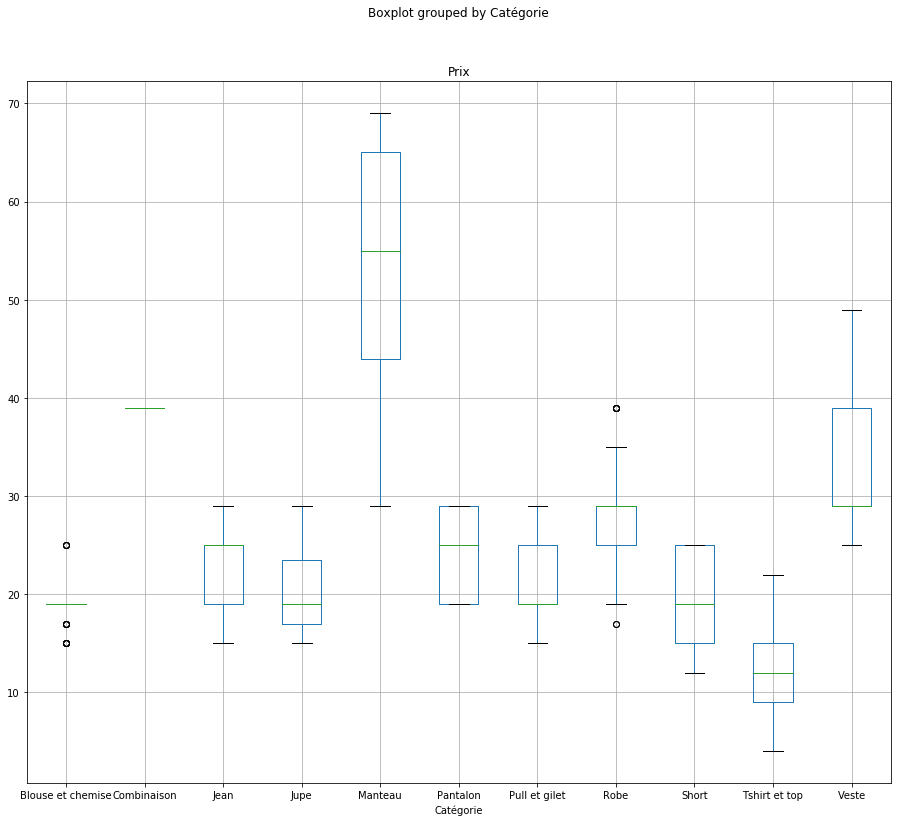

In [120]:
boxplot = df.boxplot(column=['Prix'], by = 'Catégorie', figsize=(15, 13))

In [124]:
df.Couleur.unique()

array(['kaki', 'noir', 'caramel', 'beige', 'blanc', 'vert', 'rose',
       'bleu', 'gris', 'marron', 'blanc cassé', 'camel', 'écru',
       'framboise', 'prune', 'bleu denim', 'violet', 'jaune',
       'terracotta', 'rouille', 'lilas', 'jaune moutarde', 'Camel',
       'rouge', 'bleu délavé', 'bleu brut', 'bleu ciel', 'B21A09',
       'beige poudré', 'C', 'cassonade', 'gris foncé', 'gris perle',
       'noir + rouge', 'gris anthracite', 'mauve', 'bordeaux',
       'bleu clair', 'grenat'], dtype=object)

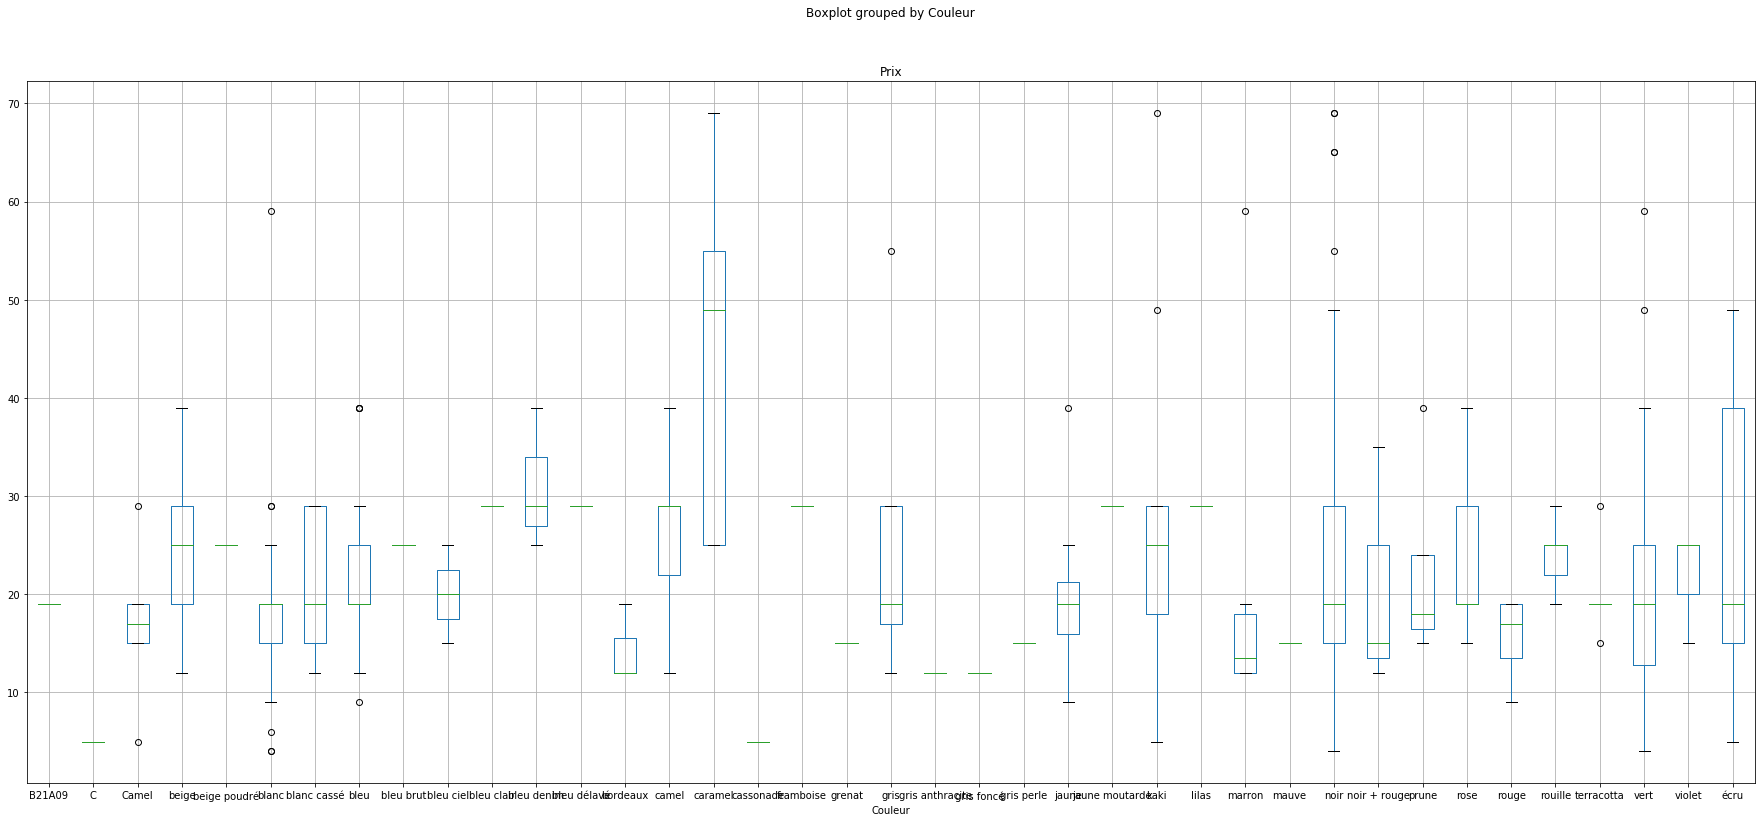

In [125]:
boxplot = df.boxplot(column=['Prix'], by = 'Couleur', figsize=(30, 13))

In [ ]:
Couleur.values